In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.io import loadmat # for reading matlab files

In [3]:
# minimizing function

from scipy.optimize import minimize

In [63]:
# alternate minimizing function

import scipy.optimize as opt # needed for the minimize function

In [4]:
# part 1

In [35]:
"""
Y is a 1682 x 943 matrix, containing ratings (1-5) of 1682 movies by 
943 users

R is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a
rating to movie i

X is 1682 x 10, containing list of 1682 movies, each with 10 features
Theta is 943 x 10, containing list of 943 users, each with 10 weights

Y is     (movies x users)    # each cell has the consolidated rating for each movie by one user
R is     (movies x users)    # each cell 1 or 0 indicating if the user has rated that movie
X is     (movies x features) # each movie with features like duration, drama, comedy, action etc
Theta is (users x wrights)   # weight each user assigns to different movie features
"""

'\nY is a 1682 x 943 matrix, containing ratings (1-5) of 1682 movies by \n943 users\n\nR is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a\nrating to movie i\n\nX is 1682 x 10, containing list of 1682 movies, each with 10 features\nTheta is 943 x 10, containing list of 943 users, each with 10 weights\n\nY is     (movies x users)    # each cell has the consolidated rating for each movie by one user\nR is     (movies x users)    # each cell 1 or 0 indicating if the user has rated that movie\nX is     (movies x features) # each movie with features like duration, drama, comedy, action etc\nTheta is (users x wrights)   # weight each user assigns to different movie features\n'

In [36]:
# load ratings data

path1 = "D:\Programming\TestData\ex8_movies.mat"
data1 = loadmat(path1)
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [37]:
Y, R = data1['Y'], data1['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [38]:
# average rating of 'i'the movie - averaging over row 'i' in R, for ratings where R[i,:] is not zero
# for 1st movie, i.e. i = 0
avgRating = np.mean(Y[0,R[0,:]])
avgRating

4.52067868504772

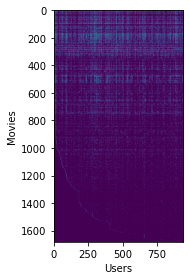

In [39]:
# visualizing the Y data of users and ratings
# we see the density of ratings

fig, ax = plt.subplots(figsize = (6,4))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()


In [40]:
# load parameters data

path2 = "D:\Programming\TestData\ex8_movieParams.mat"
data2 = loadmat(path2)
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [41]:
X, Theta, num_users, num_movies, num_features = data2['X'], data2['Theta'], data2['num_users'], data2['num_movies'], data2['num_features']
X.shape, Theta.shape, num_users.shape, num_movies.shape, num_features.shape

((1682, 10), (943, 10), (1, 1), (1, 1), (1, 1))

In [42]:
X[:2,:]

array([[ 1.0486855 , -0.40023196,  1.19411945,  0.37112768,  0.40760718,
         0.97440691, -0.05841025,  0.861721  , -0.69728994,  0.28874563],
       [ 0.78085123, -0.38562591,  0.52119779,  0.22735522,  0.57010888,
         0.64126447, -0.55000555,  0.70402073, -0.48583521, -0.56462407]])

In [43]:
num_users, num_movies, num_features

(array([[943]], dtype=uint16),
 array([[1682]], dtype=uint16),
 array([[10]], dtype=uint8))

In [44]:
# cost function

def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, learningRate):
    
    # unfold X and Theta from params
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))
    
    J = 0
    X_grad = np.zeros((X.shape))
    Theta_grad = np.zeros((Theta.shape))
    
    H = np.dot(X, Theta.T) # (movies x features) dot (features * users) = (movies x users) i.e. same as Y, R
    error = np.multiply((H - Y), R) # error dimensions same as Y, R i.e. (movies x users)
    errorSqr = np.power(error, 2)
    
    # unregularized cost
    J = (1/2) * np.sum(errorSqr)
    
    # regularized cost i.e. cost at loaded parameters
    J = J + (learningRate / 2) * np.sum(np.square(Theta)) + (learningRate / 2) * np.sum(np.square(X))
    
    # unregularized derivatives wrt feature matrix
    X_grad = np.dot(error, Theta) # (movies x users) dot (users * features) = (movies x features) i.e. same as X
    
    # unregularized derivatives wrt Theta matrix
    Theta_grad = np.dot(error.T, X) # (users x movies) dot (movies x features) = (users x features) i.e. same as Theta

    # regularized derivatives
    X_grad     =     X_grad     + (learningRate * X)
    Theta_grad =     Theta_grad + (learningRate * Theta)

    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [45]:
# creating reduced dataset - it's faster

num_users = 4
num_movies = 5
num_features = 3

XSub     = X[0:num_movies, 0:num_features]
ThetaSub = Theta[0:num_users, 0:num_features]
YSub     = Y[0:num_movies, 0:num_users]
RSub     = R[0:num_movies, 0:num_users]

paramsSub = np.concatenate((np.ravel(XSub), np.ravel(ThetaSub)))

XSub.shape, ThetaSub.shape, YSub.shape, RSub.shape, paramsSub.shape

((5, 3), (4, 3), (5, 4), (5, 4), (27,))

In [46]:
# testing cost on reduced dataset

learningRate = 1.5

cost, grad = cofiCostFunc(paramsSub, YSub, RSub, num_users, num_movies, num_features, learningRate)
cost, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [47]:
# part 2 - 

In [48]:
# load movies data 
# into dictionary movie_idx{}

movie_idx = {}

path3 = "D:\Programming\TestData\movie_ids.txt"

f = open(path3)

for line in f:
    tokens = line.strip().split(" ") # each line is split by the space separated words
    key = tokens[0] # first token is key
    movie = " ".join(tokens[1:]) # from next token, join remaining tokens with spaces to form a string
    movie_idx[int(key) - 1] = movie 
    # using zero indexing for aesthetics (see print myRatings below); 
    # note - zero indexing need not be used: keys can be anything.

In [49]:
movie_idx

{0: 'Toy Story (1995)',
 1: 'GoldenEye (1995)',
 2: 'Four Rooms (1995)',
 3: 'Get Shorty (1995)',
 4: 'Copycat (1995)',
 5: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 6: 'Twelve Monkeys (1995)',
 7: 'Babe (1995)',
 8: 'Dead Man Walking (1995)',
 9: 'Richard III (1995)',
 10: 'Seven (Se7en) (1995)',
 11: 'Usual Suspects, The (1995)',
 12: 'Mighty Aphrodite (1995)',
 13: 'Postino, Il (1994)',
 14: "Mr. Holland's Opus (1995)",
 15: 'French Twist (Gazon maudit) (1995)',
 16: 'From Dusk Till Dawn (1996)',
 17: 'White Balloon, The (1995)',
 18: "Antonia's Line (1995)",
 19: 'Angels and Insects (1995)',
 20: 'Muppet Treasure Island (1996)',
 21: 'Braveheart (1995)',
 22: 'Taxi Driver (1976)',
 23: 'Rumble in the Bronx (1995)',
 24: 'Birdcage, The (1996)',
 25: 'Brothers McMullen, The (1995)',
 26: 'Bad Boys (1995)',
 27: 'Apollo 13 (1995)',
 28: 'Batman Forever (1995)',
 29: 'Belle de jour (1967)',
 30: 'Crimson Tide (1995)',
 31: 'Crumb (1994)',
 32: 'Desperado (1995)',
 33: 'D

In [50]:
# add new user / my ratings

In [51]:
myRatings = np.zeros((1682,1))

In [52]:
# random ratings for example purposes only

myRatings[0]   = 4
myRatings[97]  = 2
myRatings[6]   = 3
myRatings[11]  = 5
myRatings[53]  = 4
myRatings[63]  = 5
myRatings[65]  = 3
myRatings[68]  = 5
myRatings[182] = 4
myRatings[225] = 5
myRatings[354] = 5

In [53]:
# printing out my ratings

n = len(myRatings)

for i in range(n):
    if myRatings[i] > 0:
        print('Rated "{}" with {} stars.'.format(movie_idx[i], str(int(myRatings[i])))) 
        # using zero indexing of dictionary created earlier for this.
    

Rated "Toy Story (1995)" with 4 stars.
Rated "Twelve Monkeys (1995)" with 3 stars.
Rated "Usual Suspects, The (1995)" with 5 stars.
Rated "Outbreak (1995)" with 4 stars.
Rated "Shawshank Redemption, The (1994)" with 5 stars.
Rated "While You Were Sleeping (1995)" with 3 stars.
Rated "Forrest Gump (1994)" with 5 stars.
Rated "Silence of the Lambs, The (1991)" with 2 stars.
Rated "Alien (1979)" with 4 stars.
Rated "Die Hard 2 (1990)" with 5 stars.
Rated "Sphere (1998)" with 5 stars.


In [54]:
# append my ratings to existing ratings datasets

Ynew = np.append(Y, myRatings, axis = 1)
Rnew = np.append(R, myRatings!=0, axis = 1)

Y.shape, Ynew.shape, R.shape, Rnew.shape # new column added

((1682, 943), (1682, 944), (1682, 943), (1682, 944))

In [55]:
# part 3 - 

# learn ratings (i.e. learn parameters based on given rating and make rating recommendations)

In [56]:
# set constants

movies = Y.shape[0]
users = Y.shape[1]
features = 10
learningRate = 10

In [57]:
# normalize ratings
# compute Mean and Normal for ratings in Y (only where rated, ignore non-rated columns)

Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((Y.shape))

for i in range(movies):
    idx = np.where(R[i,:] == 1)         # select rated columns
    Ymean[i] = Y[i,idx].mean()          # compute mean for selected columns
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]  # compute and save norm for selected columns

In [58]:
# random initialize parameters

X = np.random.random(size = (movies, features))
Theta = np.random.random(size = (users, features))

params = np.concatenate((np.ravel(X), np.ravel(Theta)))

In [59]:
# learn parametets

fmin = minimize(fun = cofiCostFunc, x0 = params, args = (Ynorm, R, users, movies, features, learningRate), 
                method = 'CG', jac = True, options = {'maxiter': 100})

fmin

     fun: 38961.245356759166
     jac: array([-0.00633506, -0.02704755, -0.02775492, ...,  0.01079391,
       -0.00189379,  0.06803856])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 146
     nit: 100
    njev: 146
  status: 1
 success: False
       x: array([ 0.42594531,  0.19515906,  0.65548595, ..., -0.02275858,
       -0.57174526, -0.16406537])

In [60]:
# extracting learned parameters

X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (943, 10))

In [61]:
# predictions based on learned parameters

predictions = np.dot(X, Theta.T) # (movies x features) dot (users x features).T = (movies x users) - same as Y, R
myPredictions = predictions[:,-1] + Ymean # my ratings were in the last column of Y
myPredictions.shape, predictions.shape

((1682, 1), (1682, 943))

In [62]:
# sort and extract indices of sorted predictions

idx = np.argsort(myPredictions, axis = 0)
for i in range(20):
    print('Predicted rating {} stars for movie "{}".'.format(str(int(myPredictions[i])), movie_idx[i]))    

Predicted rating 3 stars for movie "Toy Story (1995)".
Predicted rating 3 stars for movie "GoldenEye (1995)".
Predicted rating 3 stars for movie "Four Rooms (1995)".
Predicted rating 3 stars for movie "Get Shorty (1995)".
Predicted rating 3 stars for movie "Copycat (1995)".
Predicted rating 3 stars for movie "Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)".
Predicted rating 4 stars for movie "Twelve Monkeys (1995)".
Predicted rating 3 stars for movie "Babe (1995)".
Predicted rating 3 stars for movie "Dead Man Walking (1995)".
Predicted rating 3 stars for movie "Richard III (1995)".
Predicted rating 5 stars for movie "Seven (Se7en) (1995)".
Predicted rating 4 stars for movie "Usual Suspects, The (1995)".
Predicted rating 3 stars for movie "Mighty Aphrodite (1995)".
Predicted rating 3 stars for movie "Postino, Il (1994)".
Predicted rating 3 stars for movie "Mr. Holland's Opus (1995)".
Predicted rating 3 stars for movie "French Twist (Gazon maudit) (1995)".
Predicted rating 3 stars 

In [65]:
# part 4 

# playing around

In [64]:
result = opt.fmin_tnc(func = cofiCostFunc, x0 = params, args = (Ynorm, R, users, movies, features, learningRate))
parameters = result[0]

parameters

array([ 0.53992841,  0.4112849 ,  0.62314891, ..., -0.15814104,
       -0.60660113, -0.07880504])

In [65]:
# extracting learned parameters

X = np.matrix(np.reshape(parameters[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(parameters[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (943, 10))

In [66]:
# predictions based on learned parameters

predictions = np.dot(X, Theta.T) # (movies x features) dot (users x features).T = (movies x users) - same as Y, R
myPredictions = predictions[:,-1] + Ymean # my ratings were in the last column of Y

myPredictions.shape, predictions.shape

((1682, 1), (1682, 943))

In [67]:
# sort and extract indices of sorted predictions

idx = np.argsort(myPredictions, axis = 0)
for i in range(20):
    print('Predicted rating {} stars for movie "{}".'.format(str(int(myPredictions[i])), movie_idx[i]))    

Predicted rating 3 stars for movie "Toy Story (1995)".
Predicted rating 3 stars for movie "GoldenEye (1995)".
Predicted rating 3 stars for movie "Four Rooms (1995)".
Predicted rating 3 stars for movie "Get Shorty (1995)".
Predicted rating 3 stars for movie "Copycat (1995)".
Predicted rating 3 stars for movie "Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)".
Predicted rating 4 stars for movie "Twelve Monkeys (1995)".
Predicted rating 3 stars for movie "Babe (1995)".
Predicted rating 3 stars for movie "Dead Man Walking (1995)".
Predicted rating 3 stars for movie "Richard III (1995)".
Predicted rating 5 stars for movie "Seven (Se7en) (1995)".
Predicted rating 4 stars for movie "Usual Suspects, The (1995)".
Predicted rating 2 stars for movie "Mighty Aphrodite (1995)".
Predicted rating 3 stars for movie "Postino, Il (1994)".
Predicted rating 3 stars for movie "Mr. Holland's Opus (1995)".
Predicted rating 2 stars for movie "French Twist (Gazon maudit) (1995)".
Predicted rating 3 stars 